Please find torch implementation of this notebook here: https://colab.research.google.com/github/probml/pyprobml/blob/master/notebooks/book1/19/image_augmentation_torch.ipynb

<a href="https://colab.research.google.com/drive/19aCO4g8K5CPGFYOOOaKHXNhtbt--lYVL?usp=sharing">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

**AUTHOR** : Susnato Dhar (Github : https://github.com/susnato) 



**IMAGE AUGMENTATION**

This Notebook shows how to apply Image Augmentation using JAX, based on 13.1. of http://d2l.ai/chapter_computer-vision/image-augmentation.html



**ACKNOWLEDGEMENTS & MENTIONS**

<ul>
  <li>This Notebook uses <a href="https://github.com/khdlr/augmax">Augmax</a> made by <a href="https://github.com/khdlr">Konrad Heidler</a>. Which is an Image Data Augmentation Framework with support for JAX function transformations.</li>

  <li>Some code of this Notebook greatly resembles from this original <a href="https://github.com/probml/probml-notebooks/blob/main/notebooks-d2l/image_augmentation_torch.ipynb">Notebook</a> which has support for PyTorch.</li>
  
  <li>We only use Tensorflow for Data Loading Purposes in other cases we stick to JAX.</li>
</ul>

**Cloning `AUGMAX` Repository & Installing it**

**I took the image from github repo but feel free to use your own.**

In [24]:
!cd /content
!wget https://github.com/probml/probml-notebooks/blob/main/images/cat_dog.jpg?raw=true
!mv '/content/cat_dog.jpg?raw=true' '/content/cat_dog.jpg'

--2022-06-08 20:40:35--  https://github.com/probml/probml-notebooks/blob/main/images/cat_dog.jpg?raw=true
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://github.com/probml/probml-notebooks/raw/main/images/cat_dog.jpg [following]
--2022-06-08 20:40:35--  https://github.com/probml/probml-notebooks/raw/main/images/cat_dog.jpg
Reusing existing connection to github.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/probml/probml-notebooks/main/images/cat_dog.jpg [following]
--2022-06-08 20:40:35--  https://raw.githubusercontent.com/probml/probml-notebooks/main/images/cat_dog.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HT

In [25]:
try:
    import cv2
except ModuleNotFoundError:
    %pip install -qq opencv-python
    import cv2
import jax

try:
    import augmax
except ModuleNotFoundError:
    %pip install -qq git+https://github.com/khdlr/augmax.git -q
    import augmax
from jax import numpy as jnp
from jax import random as jrand

try:
    from skimage.util import montage
except ModuleNotFoundError:
    %pip install -qq scikit-image
    from skimage.util import montage

try:
    import tensorflow_datasets as tfds
except ModuleNotFoundError:
    %pip install -qq tensorflow tensorflow_datasets
    import tensorflow_datasets as tfds

import matplotlib.pyplot as plt

%matplotlib inline

In [26]:
seed = 42
rng = jax.random.PRNGKey(seed)

In [27]:
def show_images(imgs, num_rows, num_cols, titles=None, scale=1.5):
    """Plot a list of images."""
    if len(imgs) == 1:
        plt.imshow(imgs[0])
        plt.title("Cat And Dog")
        plt.show()

    elif len(imgs) == 2:
        figsize = (num_cols * scale, num_rows * scale)
        fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
        axes[0].imshow(imgs[0])
        axes[0].set_title(titles[0])
        axes[1].imshow(imgs[1])
        axes[1].set_title(titles[1])
        plt.show()

    else:
        num_rows = (
            2 if num_rows < 2 else num_rows
        )  # no of rows must be greater than equal to 2 in order for the indexing to work in axes
        num_cols = (
            2 if num_cols < 2 else num_cols
        )  # no of cols must be greater than equal to 2 in order for the indexing to work in axes
        figsize = (num_cols * scale, num_rows * scale)
        fig, axes = plt.subplots(num_rows, num_cols, figsize=figsize)
        count = 0
        for i in range(num_rows):  # for i
            for j in range(num_cols):  # for j
                axes[i, j].imshow(imgs[count])
                axes[i, j].axes.get_xaxis().set_visible(True)
                axes[i, j].axes.get_yaxis().set_visible(True)
                if titles:
                    axes[i, j].set_title(titles[count])
                count += 1
                if count >= len(imgs):
                    break
        plt.tight_layout()

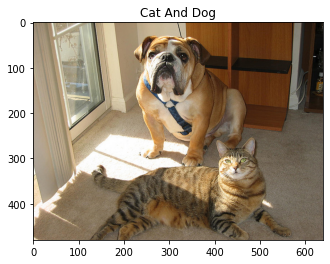

In [28]:
img = cv2.imread("/content/cat_dog.jpg")
# When we load an image using Open-Cv it's opened in "BGR" format, let's change it to "RGB"
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

show_images([img], titles=["Cat&Dog"], num_rows=1, num_cols=1, scale=3)

To visualize an image augmentation, which may be stochastic, we apply it multiple times to an image.

In [29]:
def apply(img, aug, rng, num_rows=2, num_cols=2, scale=3):
    Y = []
    for i in range(num_rows * num_cols):
        transformed_img = aug(rng, img)
        Y.append(transformed_img)
        rng, subkey = jrand.split(rng)
    # Just to make sure that at least 1 image will be augmented if somehow all the
    # probabilities are not in favour of augmenting the image.
    show_images(Y, num_rows, num_cols, scale=scale)

# Flipping

In [30]:
h_flip_transform = augmax.HorizontalFlip()  # HORIZONTAL FLIP
v_flip_transform = augmax.VerticalFlip()  # VERTICAL FLIP

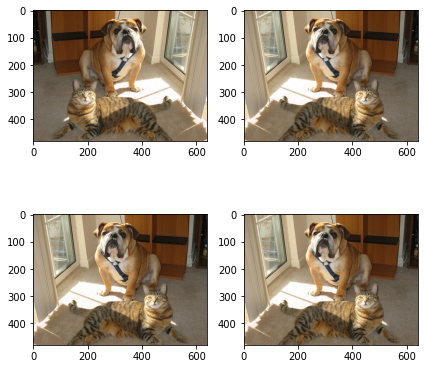

In [31]:
apply(img=img, aug=h_flip_transform, rng=rng)  # HORIZONTAL FLIP

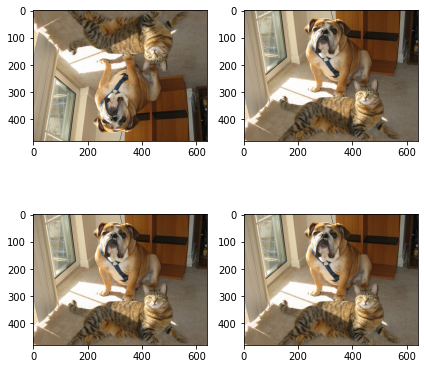

In [32]:
apply(img=img, aug=v_flip_transform, rng=rng)  # VERTICAL FLIP

# Crop and resize

Below, we randomly crop a region with an area of 10% to 100% of the original area, and the ratio of width to height of the region is randomly selected from between 0.5 and 2. Then, the width and height of the region are both scaled to 200 pixels.

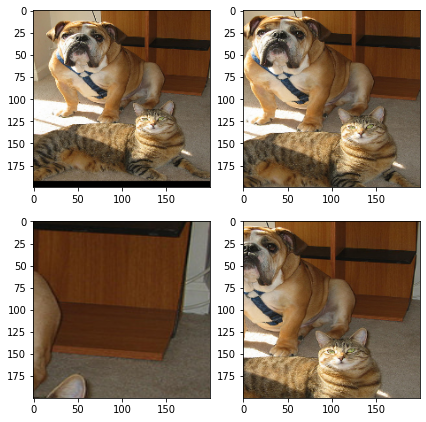

In [33]:
crop_transform = augmax.RandomSizedCrop(int(img.shape[0] / 2), int(img.shape[1] / 2))
resize_transform = augmax.Resize(200, 200)
crop_and_resize_transform = augmax.Chain(crop_transform, resize_transform)

apply(img=img, aug=crop_and_resize_transform, rng=rng)

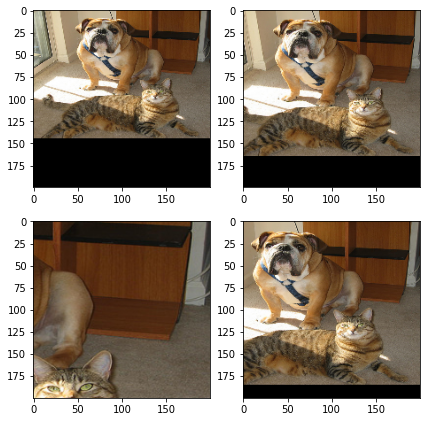

In [34]:
crop_transform = augmax.RandomSizedCrop(int(img.shape[0] / 1.5), int(img.shape[1] / 1.5))
resize_transform = augmax.Resize(200, 200)
crop_and_resize_transform = augmax.Chain(crop_transform, resize_transform)

apply(img=img, aug=crop_and_resize_transform, rng=rng)

# Changing color

We can change brightness, contrast, saturation and hue. First we change brightness, from 1-0.5=0.5 times less to 1+0.5=1.5 times more.

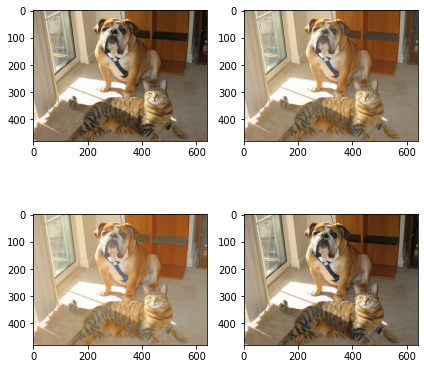

In [35]:
byte2float_transform = augmax.ByteToFloat()
brightness_transform = augmax.ColorJitter(brightness=0.5, contrast=0, saturation=0, hue=0)

byte2float_brightness_transform = augmax.Chain(byte2float_transform, brightness_transform)

apply(img=img, aug=byte2float_brightness_transform, rng=rng)



Now we change hue.


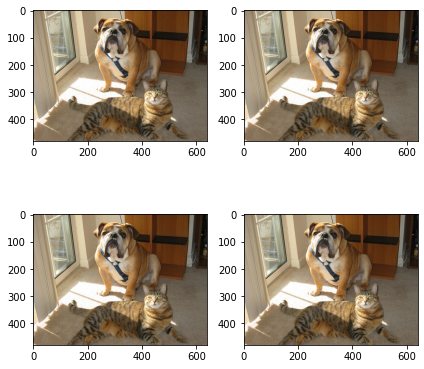

In [36]:
byte2float_transform = augmax.ByteToFloat()
hue_transform = augmax.ColorJitter(brightness=0, contrast=0, saturation=0, hue=0.5)

byte2float_hue_transform = augmax.Chain(byte2float_transform, hue_transform)

apply(img=img, aug=byte2float_hue_transform, rng=rng)

Now we change saturation.

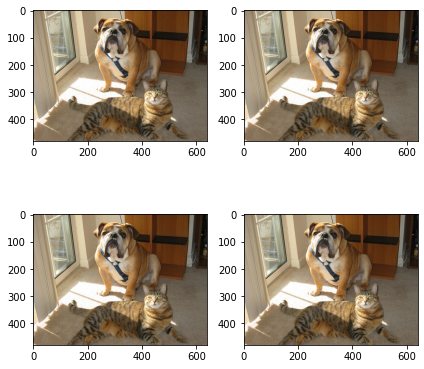

In [37]:
byte2float_transform = augmax.ByteToFloat()
saturation_transform = augmax.ColorJitter(brightness=0, contrast=0, saturation=1, hue=0)

byte2float_saturation_transform = augmax.Chain(byte2float_transform, saturation_transform)

apply(img=img, aug=byte2float_saturation_transform, rng=rng)



Now we change contrast.


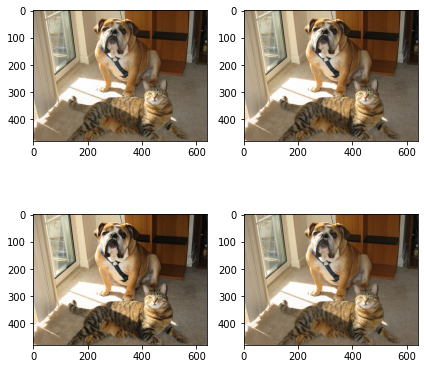

In [38]:
byte2float_transform = augmax.ByteToFloat()
contrast_transform = augmax.ColorJitter(brightness=0, contrast=0.5, saturation=0, hue=0)

byte2float_contrast_transform = augmax.Chain(byte2float_transform, contrast_transform)

apply(img=img, aug=byte2float_contrast_transform, rng=rng)

# Combining multiple augmentations in a pipeline

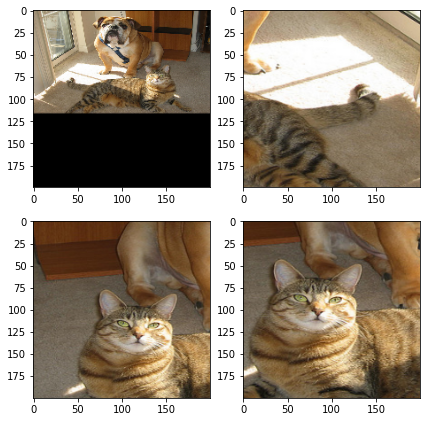

In [39]:
augs1 = augmax.Chain(crop_and_resize_transform, h_flip_transform, byte2float_brightness_transform)
apply(img=img, aug=augs1, rng=rng)

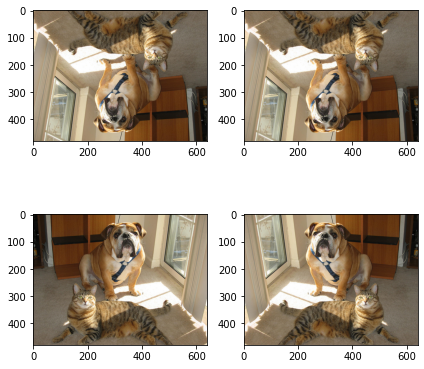

In [40]:
augs2 = augmax.Chain(h_flip_transform, v_flip_transform, byte2float_hue_transform)
apply(img=img, aug=augs2, rng=rng)

# Using augmentations in a dataloader

We illustrate how we can transform training and test images from CIFAR10.



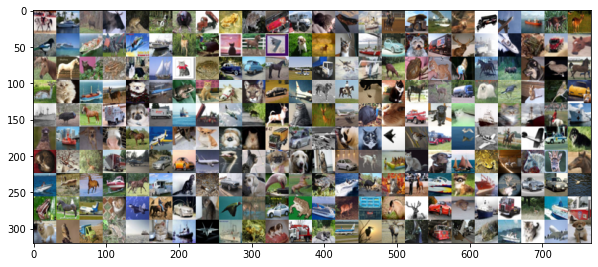

In [41]:
"""
Let's download the CIFAR10 dataset and view some of it's images
"""
all_images = tfds.load("cifar10", split=["train"], as_supervised=True)

for i in all_images[0].batch(240).take(1):
    plt.figure(figsize=(10, 10))
    plt.imshow(montage(i[0].numpy(), multichannel=True, rescale_intensity=False, grid_shape=(10, 24)))
    plt.show();

In [42]:
"""
Create Augmentation Pipelines in JAX(If you want you can add other augmentations described above,
                                     for now I am only going for the HorizontalFlip)
"""
train_augs = augmax.Chain(
    augmax.HorizontalFlip(),
)
test_augs = augmax.Chain(
    augmax.HorizontalFlip(),
)

In [43]:
"""
We are using Tensorflow only for Downloading the DataSet and DataLoader purposes.
"""


def load_cifar10(batch_size):
    train_ds, test_ds = tfds.load("cifar10", split=["train", "test"], as_supervised=True)

    train_ds = train_ds.batch(batch_size)
    test_ds = test_ds.batch(batch_size)

    return train_ds, test_ds

0
<class 'jaxlib.xla_extension.DeviceArray'>
(64, 32, 32, 3)


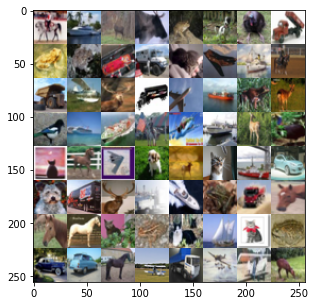

1
<class 'jaxlib.xla_extension.DeviceArray'>
(64, 32, 32, 3)


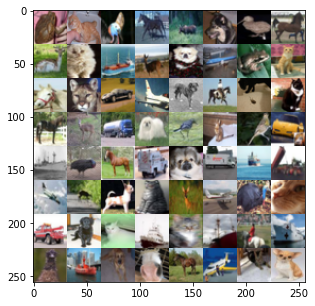

In [44]:
"""
First Load Data using Tensorflow Datasets then convert those batches into JAX Numpy Array.
"""

train_ds, test_ds = load_cifar10(64)
for i, (features, labels) in enumerate(train_ds):
    print(i)
    features = jnp.array([train_augs(rng, ef.numpy()) for ef in features])
    print(type(features))
    print(features.shape)
    plt.figure(figsize=(5, 5))
    plt.imshow(montage(features, multichannel=True, rescale_intensity=False, grid_shape=(8, 8)))
    plt.show()
    if i >= 1:
        break